<a href="https://colab.research.google.com/github/Lcocks/DS6050-DeepLearning/blob/main/6_1_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders

## PCA and LinAE, NonlinAE

AUTOENCODER TUTORIAL: FROM LINEAR TO NONLINEAR TO TRANSLATION

PART 1: PROVING PCA = LINEAR AUTOENCODER

Generating synthetic data on 2D manifold in 50D space...
Data shape: torch.Size([1000, 50])
True intrinsic dimension: 2
Ambient dimension: 50

1. Fitting PCA...
   PCA reconstruction error: 0.009671
   Explained variance ratio: [0.6065706  0.38822567]

2. Training Linear Autoencoder...
   Epoch   0: Loss = 1.857878
   Epoch 100: Loss = 0.009733
   Epoch 200: Loss = 0.009671
   Epoch 300: Loss = 0.009671
   Epoch 400: Loss = 0.009671
   Linear AE reconstruction error: 0.009671

3. Comparing learned subspaces...
   Subspace difference (Frobenius norm): 0.000000
   ✓ EQUIVALENT subspaces!


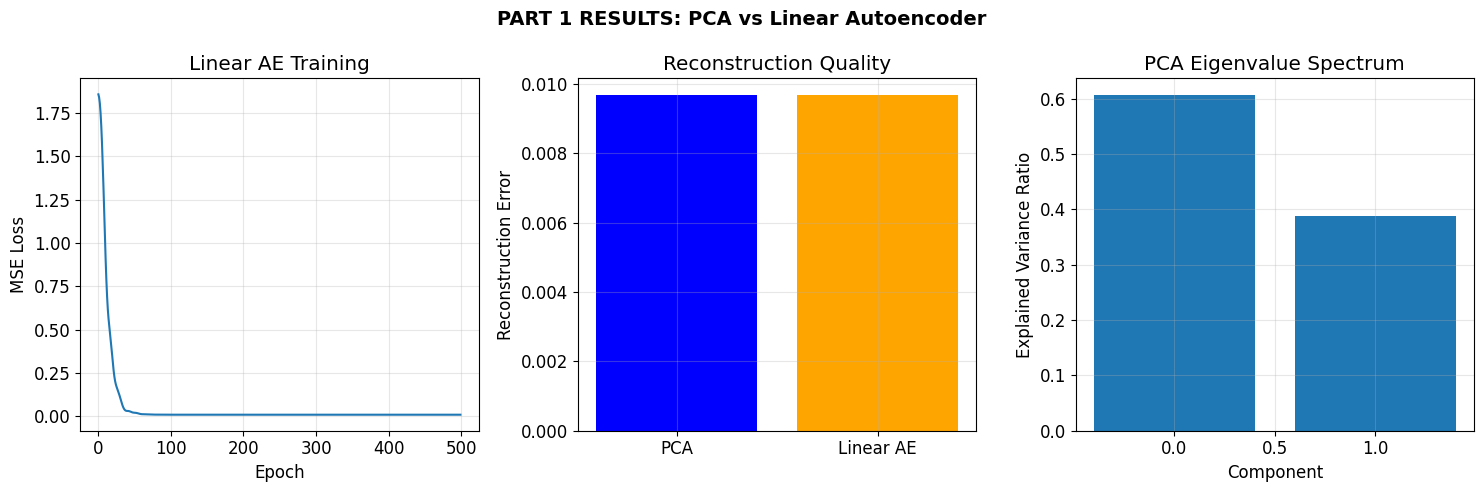


KEY INSIGHT #1: Linear autoencoders naturally discover PCA through gradient descent!
This is profound - optimization finds the 'right' representation automatically.

PART 2: NONLINEAR AUTOENCODERS FOR CURVED MANIFOLDS

Generating Swiss Roll dataset...
Swiss Roll shape: torch.Size([2000, 3])
Intrinsic dimension: 2 (it's a rolled-up 2D sheet)
Ambient dimension: 3

1. PCA (Linear compression):
   Reconstruction error: 0.296660

2. Linear Autoencoder:
   Reconstruction error: 0.297411

3. Nonlinear Autoencoder:
   Epoch   0: Loss = 1.189281
   Epoch 100: Loss = 0.153553
   Epoch 200: Loss = 0.089773
   Epoch 300: Loss = 0.062906
   Epoch 400: Loss = 0.051654
   Final reconstruction error: 0.042516


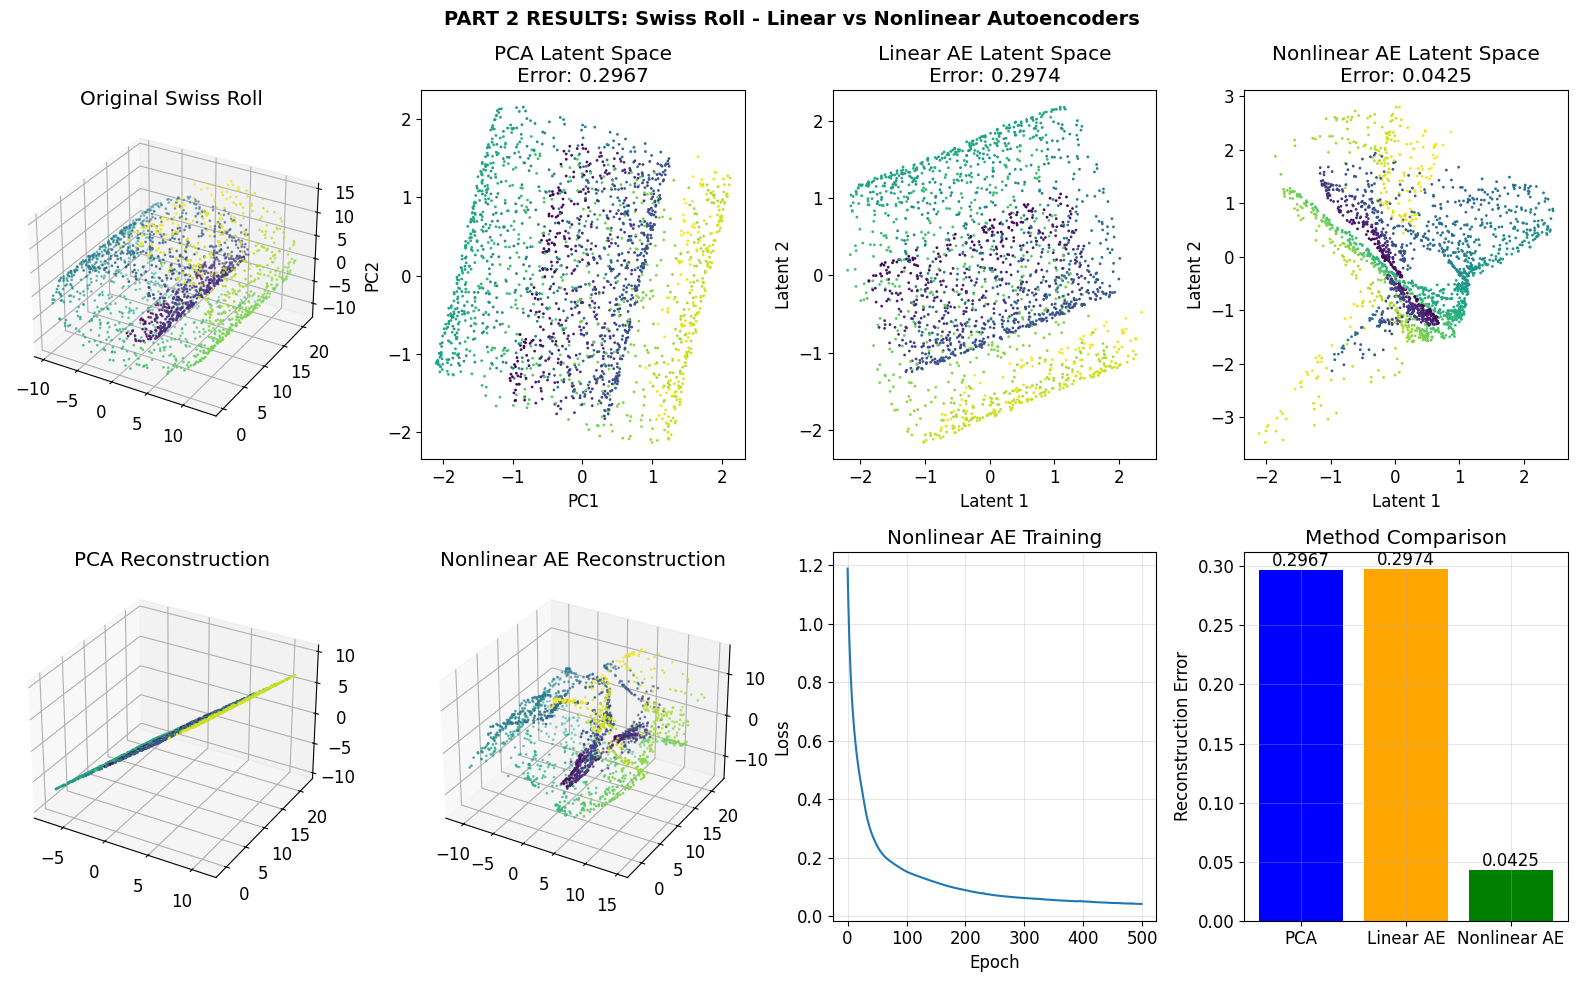


----------------------------------------
RESULTS COMPARISON:
----------------------------------------
PCA Error:         0.296660
Linear AE Error:   0.297411
Nonlinear Error:   0.042516

Improvement (Nonlinear vs PCA): 85.7%

KEY INSIGHT #2: Nonlinear autoencoders can 'unroll' curved manifolds!
They learn the intrinsic structure, not just the best linear approximation.


In [ ]:
"""
================================================================================
LECTURE 6: FROM IMPLICIT TO EXPLICIT REPRESENTATION LEARNING
The Encoder-Decoder Bridge to Sequence Modeling

This tutorial demonstrates three fundamental concepts:
PART 1: PCA and Linear Autoencoders are mathematically equivalent
PART 2: Nonlinear Autoencoders excel at learning curved manifolds (Swiss Roll)
PART 3: CNN Autoencoders

Key Learning Objectives:
- Understand why compression requires understanding
- See how gradient descent naturally discovers PCA solution
- Learn how nonlinearity enables curved manifold learning
- Apply encoder-decoder to real translation tasks
================================================================================
"""

print("="*80)
print("AUTOENCODER TUTORIAL: FROM LINEAR TO NONLINEAR TO TRANSLATION")
print("="*80)

# ============================================================================
# PART 1: PCA VS LINEAR AUTOENCODER - THE SURPRISING EQUIVALENCE
# ============================================================================

print("\n" + "="*80)
print("PART 1: PROVING PCA = LINEAR AUTOENCODER")
print("="*80)

# Part 1 imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Configure matplotlib
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

class PCACompressor:
    """
    Principal Component Analysis: The optimal linear compression method.

    Mathematical foundation:
    - PCA finds directions of maximum variance
    - These directions are eigenvectors of the covariance matrix
    - Projection onto top-k eigenvectors gives optimal linear compression

    Key insight: PCA solves the optimization problem:
        min ||X - X_reconstructed||²  subject to rank(W) = k
    """

    def __init__(self, n_components):
        self.n_components = n_components
        self.components_ = None  # Will store eigenvectors
        self.mean_ = None
        self.explained_variance_ratio_ = None

    def fit(self, X):
        """
        Learn the principal components via SVD.

        Why SVD instead of eigendecomposition?
        1. More numerically stable
        2. Avoids computing X^T X (which squares condition number)
        3. Directly gives us singular values (related to eigenvalues)
        """
        # CRITICAL: Center the data (PCA requires zero mean)
        self.mean_ = X.mean(dim=0, keepdim=True)
        X_centered = X - self.mean_

        # SVD: X = U @ S @ V^T
        # V columns are eigenvectors of X^T X (what we want!)
        U, S, Vh = torch.linalg.svd(X_centered, full_matrices=False)

        # Extract top-k components
        self.components_ = Vh[:self.n_components].T  # Shape: (n_features, k)

        # Calculate explained variance
        variance = S**2 / (X.shape[0] - 1)
        self.explained_variance_ratio_ = variance[:self.n_components] / variance.sum()

        return self

    def encode(self, X):
        """Project data onto principal components."""
        X_centered = X - self.mean_
        return X_centered @ self.components_  # Shape: (n_samples, k)

    def decode(self, Z):
        """Reconstruct from latent representation."""
        X_centered_recon = Z @ self.components_.T
        return X_centered_recon + self.mean_

    def reconstruction_error(self, X):
        """Calculate MSE reconstruction error."""
        Z = self.encode(X)
        X_recon = self.decode(Z)
        return F.mse_loss(X, X_recon).item()

class LinearAutoencoder(nn.Module):
    """
    Linear autoencoder with tied weights.

    THEOREM (Baldi & Hornik, 1989):
    A linear autoencoder with:
    - MSE loss
    - Tied weights (W_decode = W_encode^T)
    - Trained to convergence

    Spans the SAME subspace as PCA!

    The weights may differ by a rotation, but the subspace is identical.
    This means gradient descent naturally discovers the "right" representation.
    """

    def __init__(self, input_dim, latent_dim):
        super().__init__()

        # Single weight matrix - decoder uses transpose (tied weights)
        # Initialize small to avoid saturation
        self.W = nn.Parameter(torch.randn(input_dim, latent_dim) * 0.01)

        self.input_dim = input_dim
        self.latent_dim = latent_dim

    def encode(self, x):
        """Linear projection: z = x @ W"""
        return x @ self.W

    def decode(self, z):
        """Transpose projection: x_hat = z @ W^T"""
        return z @ self.W.T

    def forward(self, x):
        z = self.encode(x)
        x_recon = self.decode(z)
        return x_recon, z

    def get_projection_matrix(self):
        """
        Get the projection matrix P = W @ W^T.
        This defines the subspace spanned by the autoencoder.
        """
        with torch.no_grad():
            return self.W @ self.W.T

def demonstrate_pca_linear_ae_equivalence():
    """
    Empirically prove that PCA and Linear AE learn the same subspace.

    Setup:
    1. Create data on a 2D linear manifold in 50D space
    2. Train both PCA and Linear AE
    3. Compare their learned subspaces
    """

    print("\nGenerating synthetic data on 2D manifold in 50D space...")

    # Create structured data: 2D manifold in 50D
    true_dim = 2
    ambient_dim = 50
    n_samples = 1000

    # Generate data: X = Z @ W + noise
    W_true = torch.randn(true_dim, ambient_dim)
    Z_true = torch.randn(n_samples, true_dim)
    X = Z_true @ W_true + 0.1 * torch.randn(n_samples, ambient_dim)

    print(f"Data shape: {X.shape}")
    print(f"True intrinsic dimension: {true_dim}")
    print(f"Ambient dimension: {ambient_dim}")

    # Method 1: PCA
    print("\n1. Fitting PCA...")
    pca = PCACompressor(n_components=true_dim)
    pca.fit(X)
    pca_error = pca.reconstruction_error(X)
    print(f"   PCA reconstruction error: {pca_error:.6f}")
    print(f"   Explained variance ratio: {pca.explained_variance_ratio_.numpy()}")

    # Method 2: Linear Autoencoder
    print("\n2. Training Linear Autoencoder...")
    linear_ae = LinearAutoencoder(ambient_dim, true_dim)
    optimizer = torch.optim.Adam(linear_ae.parameters(), lr=0.01)

    # Center data (like PCA does)
    X_mean = X.mean(dim=0, keepdim=True)
    X_centered = X - X_mean

    # Training loop
    losses = []
    for epoch in range(500):
        x_recon, z = linear_ae(X_centered)
        loss = F.mse_loss(x_recon, X_centered)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if epoch % 100 == 0:
            print(f"   Epoch {epoch:3d}: Loss = {loss:.6f}")

    # Final error
    with torch.no_grad():
        x_recon, _ = linear_ae(X_centered)
        ae_error = F.mse_loss(x_recon + X_mean, X).item()
    print(f"   Linear AE reconstruction error: {ae_error:.6f}")

    # Compare subspaces
    print("\n3. Comparing learned subspaces...")

    # Get projection matrices
    W_pca = pca.components_
    P_pca = W_pca @ W_pca.T

    P_ae = linear_ae.get_projection_matrix()

    # Subspace distance (Frobenius norm of difference)
    subspace_diff = torch.norm(P_pca - P_ae, 'fro').item()

    print(f"   Subspace difference (Frobenius norm): {subspace_diff:.6f}")
    print(f"   {'✓ EQUIVALENT' if subspace_diff < 0.5 else '✗ DIFFERENT'} subspaces!")

    # Visualize results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot 1: Training loss
    axes[0].plot(losses)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('MSE Loss')
    axes[0].set_title('Linear AE Training')
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Reconstruction errors
    methods = ['PCA', 'Linear AE']
    errors = [pca_error, ae_error]
    axes[1].bar(methods, errors, color=['blue', 'orange'])
    axes[1].set_ylabel('Reconstruction Error')
    axes[1].set_title('Reconstruction Quality')
    axes[1].grid(True, alpha=0.3)

    # Plot 3: Eigenvalue spectrum
    axes[2].bar(range(len(pca.explained_variance_ratio_)),
                pca.explained_variance_ratio_.numpy())
    axes[2].set_xlabel('Component')
    axes[2].set_ylabel('Explained Variance Ratio')
    axes[2].set_title('PCA Eigenvalue Spectrum')
    axes[2].grid(True, alpha=0.3)

    plt.suptitle('PART 1 RESULTS: PCA vs Linear Autoencoder', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return X, pca, linear_ae

# Run Part 1
X_linear, pca_model, linear_ae_model = demonstrate_pca_linear_ae_equivalence()

print("\n" + "="*80)
print("KEY INSIGHT #1: Linear autoencoders naturally discover PCA through gradient descent!")
print("This is profound - optimization finds the 'right' representation automatically.")
print("="*80)

# ============================================================================
# PART 2: NONLINEAR AUTOENCODER - LEARNING CURVED MANIFOLDS
# ============================================================================

print("\n" + "="*80)
print("PART 2: NONLINEAR AUTOENCODERS FOR CURVED MANIFOLDS")
print("="*80)

# Part 2 imports (additional)
from sklearn.datasets import make_swiss_roll

class NonlinearAutoencoder(nn.Module):
    """
    Deep nonlinear autoencoder.

    Key advantages over linear (PCA):
    1. Can learn curved manifolds (not just flat subspaces)
    2. Captures complex, hierarchical features
    3. Better compression for naturally nonlinear data

    Example: Swiss Roll
    - Linear methods: Project onto best plane (loses spiral structure)
    - Nonlinear AE: Can "unroll" the spiral (preserves intrinsic structure)
    """

    def __init__(self, input_dim, latent_dim, hidden_dims=[128, 64, 32]):
        super().__init__()

        # Build encoder
        encoder_layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            encoder_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),  # Nonlinearity is CRUCIAL for learning curves!
                nn.BatchNorm1d(hidden_dim)  # Stabilizes training
            ])
            prev_dim = hidden_dim

        # Final projection to latent (no activation)
        encoder_layers.append(nn.Linear(prev_dim, latent_dim))
        self.encoder = nn.Sequential(*encoder_layers)

        # Build decoder (mirror architecture)
        decoder_layers = []
        prev_dim = latent_dim

        for hidden_dim in reversed(hidden_dims):
            decoder_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dim)
            ])
            prev_dim = hidden_dim

        # Final reconstruction (no activation)
        decoder_layers.append(nn.Linear(prev_dim, input_dim))
        self.decoder = nn.Sequential(*decoder_layers)

        self.input_dim = input_dim
        self.latent_dim = latent_dim

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        x_recon = self.decode(z)
        return x_recon, z

def swiss_roll_experiment():
    """
    Classic experiment demonstrating superiority of nonlinear autoencoders.

    Swiss Roll: A 2D manifold curved in 3D space
    - Intrinsically 2D (can be unrolled to a plane)
    - But embedded in 3D via a spiral

    PCA fails because it can only find linear subspaces.
    Nonlinear AE succeeds because it can learn the unrolling transformation.
    """

    print("\nGenerating Swiss Roll dataset...")

    # Generate Swiss Roll
    n_samples = 2000
    X_3d, color = make_swiss_roll(n_samples, noise=0.1, random_state=42)
    X_3d = torch.tensor(X_3d, dtype=torch.float32)

    # Normalize for stable training
    X_mean = X_3d.mean(dim=0, keepdim=True)
    X_std = X_3d.std(dim=0, keepdim=True)
    X_normalized = (X_3d - X_mean) / (X_std + 1e-8)

    print(f"Swiss Roll shape: {X_3d.shape}")
    print(f"Intrinsic dimension: 2 (it's a rolled-up 2D sheet)")
    print(f"Ambient dimension: 3")

    # Method 1: PCA
    print("\n1. PCA (Linear compression):")
    pca = PCACompressor(n_components=2)
    pca.fit(X_normalized)
    X_pca_latent = pca.encode(X_normalized)
    X_pca_recon = pca.decode(X_pca_latent)
    pca_error = F.mse_loss(X_normalized, X_pca_recon).item()
    print(f"   Reconstruction error: {pca_error:.6f}")

    # Method 2: Linear Autoencoder
    print("\n2. Linear Autoencoder:")
    linear_ae = LinearAutoencoder(input_dim=3, latent_dim=2)
    optimizer = torch.optim.Adam(linear_ae.parameters(), lr=0.01)

    for epoch in range(300):
        x_recon, z = linear_ae(X_normalized)
        loss = F.mse_loss(x_recon, X_normalized)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        X_linear_recon, X_linear_latent = linear_ae(X_normalized)
        linear_error = F.mse_loss(X_normalized, X_linear_recon).item()
    print(f"   Reconstruction error: {linear_error:.6f}")

    # Method 3: Nonlinear Autoencoder
    print("\n3. Nonlinear Autoencoder:")
    nonlinear_ae = NonlinearAutoencoder(
        input_dim=3,
        latent_dim=2,
        hidden_dims=[32, 16]  # Smaller network for Swiss Roll
    )
    optimizer = torch.optim.Adam(nonlinear_ae.parameters(), lr=0.001)

    # Training with progress tracking
    losses = []
    for epoch in range(500):
        x_recon, z = nonlinear_ae(X_normalized)
        loss = F.mse_loss(x_recon, X_normalized)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if epoch % 100 == 0:
            print(f"   Epoch {epoch:3d}: Loss = {loss:.6f}")

    with torch.no_grad():
        X_nonlinear_recon, X_nonlinear_latent = nonlinear_ae(X_normalized)
        nonlinear_error = F.mse_loss(X_normalized, X_nonlinear_recon).item()
    print(f"   Final reconstruction error: {nonlinear_error:.6f}")

    # Visualize results
    fig = plt.figure(figsize=(16, 10))

    # Original Swiss Roll
    ax1 = fig.add_subplot(2, 4, 1, projection='3d')
    ax1.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c=color, cmap='viridis', s=1)
    ax1.set_title('Original Swiss Roll')

    # PCA latent space
    ax2 = fig.add_subplot(2, 4, 2)
    ax2.scatter(X_pca_latent[:, 0], X_pca_latent[:, 1], c=color, cmap='viridis', s=1)
    ax2.set_title(f'PCA Latent Space\nError: {pca_error:.4f}')
    ax2.set_xlabel('PC1')
    ax2.set_ylabel('PC2')

    # Linear AE latent space
    ax3 = fig.add_subplot(2, 4, 3)
    ax3.scatter(X_linear_latent[:, 0].detach(), X_linear_latent[:, 1].detach(),
                c=color, cmap='viridis', s=1)
    ax3.set_title(f'Linear AE Latent Space\nError: {linear_error:.4f}')
    ax3.set_xlabel('Latent 1')
    ax3.set_ylabel('Latent 2')

    # Nonlinear AE latent space
    ax4 = fig.add_subplot(2, 4, 4)
    ax4.scatter(X_nonlinear_latent[:, 0].detach(), X_nonlinear_latent[:, 1].detach(),
                c=color, cmap='viridis', s=1)
    ax4.set_title(f'Nonlinear AE Latent Space\nError: {nonlinear_error:.4f}')
    ax4.set_xlabel('Latent 1')
    ax4.set_ylabel('Latent 2')

    # Reconstructions
    X_pca_recon_denorm = X_pca_recon * X_std + X_mean
    X_nonlinear_recon_denorm = X_nonlinear_recon * X_std + X_mean

    ax5 = fig.add_subplot(2, 4, 5, projection='3d')
    ax5.scatter(X_pca_recon_denorm[:, 0], X_pca_recon_denorm[:, 1],
                X_pca_recon_denorm[:, 2], c=color, cmap='viridis', s=1)
    ax5.set_title('PCA Reconstruction')

    ax6 = fig.add_subplot(2, 4, 6, projection='3d')
    ax6.scatter(X_nonlinear_recon_denorm[:, 0].detach(),
                X_nonlinear_recon_denorm[:, 1].detach(),
                X_nonlinear_recon_denorm[:, 2].detach(),
                c=color, cmap='viridis', s=1)
    ax6.set_title('Nonlinear AE Reconstruction')

    # Training curve
    ax7 = fig.add_subplot(2, 4, 7)
    ax7.plot(losses)
    ax7.set_xlabel('Epoch')
    ax7.set_ylabel('Loss')
    ax7.set_title('Nonlinear AE Training')
    ax7.grid(True, alpha=0.3)

    # Error comparison
    ax8 = fig.add_subplot(2, 4, 8)
    methods = ['PCA', 'Linear AE', 'Nonlinear AE']
    errors = [pca_error, linear_error, nonlinear_error]
    bars = ax8.bar(methods, errors, color=['blue', 'orange', 'green'])
    ax8.set_ylabel('Reconstruction Error')
    ax8.set_title('Method Comparison')
    ax8.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar, error in zip(bars, errors):
        height = bar.get_height()
        ax8.text(bar.get_x() + bar.get_width()/2., height,
                f'{error:.4f}', ha='center', va='bottom')

    plt.suptitle('PART 2 RESULTS: Swiss Roll - Linear vs Nonlinear Autoencoders',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Print summary
    print("\n" + "-"*40)
    print("RESULTS COMPARISON:")
    print("-"*40)
    print(f"PCA Error:         {pca_error:.6f}")
    print(f"Linear AE Error:   {linear_error:.6f}")
    print(f"Nonlinear Error:   {nonlinear_error:.6f}")
    improvement = (pca_error - nonlinear_error) / pca_error * 100
    print(f"\nImprovement (Nonlinear vs PCA): {improvement:.1f}%")

    return X_nonlinear_latent.detach(), color

# Run Part 2
latent_representation, color_map = swiss_roll_experiment()

print("\n" + "="*80)
print("KEY INSIGHT #2: Nonlinear autoencoders can 'unroll' curved manifolds!")
print("They learn the intrinsic structure, not just the best linear approximation.")
print("="*80)


## CNN AE


PART 3: CNN AUTOENCODER FOR MNIST IMAGE COMPRESSION

Setting up CNN Autoencoder training for MNIST...
Loading MNIST dataset...


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.48MB/s]


Model parameters: 4,008,513

Training CNN Autoencoder on MNIST...
  Epoch [1/5], Batch [0/79], Loss: 0.7732
  Epoch [1/5], Batch [50/79], Loss: 0.1273
Epoch [1/5] Average Loss: 0.1681
  Epoch [2/5], Batch [0/79], Loss: 0.0821
  Epoch [2/5], Batch [50/79], Loss: 0.0399
Epoch [2/5] Average Loss: 0.0439
  Epoch [3/5], Batch [0/79], Loss: 0.0284
  Epoch [3/5], Batch [50/79], Loss: 0.0201
Epoch [3/5] Average Loss: 0.0232
  Epoch [4/5], Batch [0/79], Loss: 0.0222
  Epoch [4/5], Batch [50/79], Loss: 0.0145
Epoch [4/5] Average Loss: 0.0167
  Epoch [5/5], Batch [0/79], Loss: 0.0143
  Epoch [5/5], Batch [50/79], Loss: 0.0182
Epoch [5/5] Average Loss: 0.0153


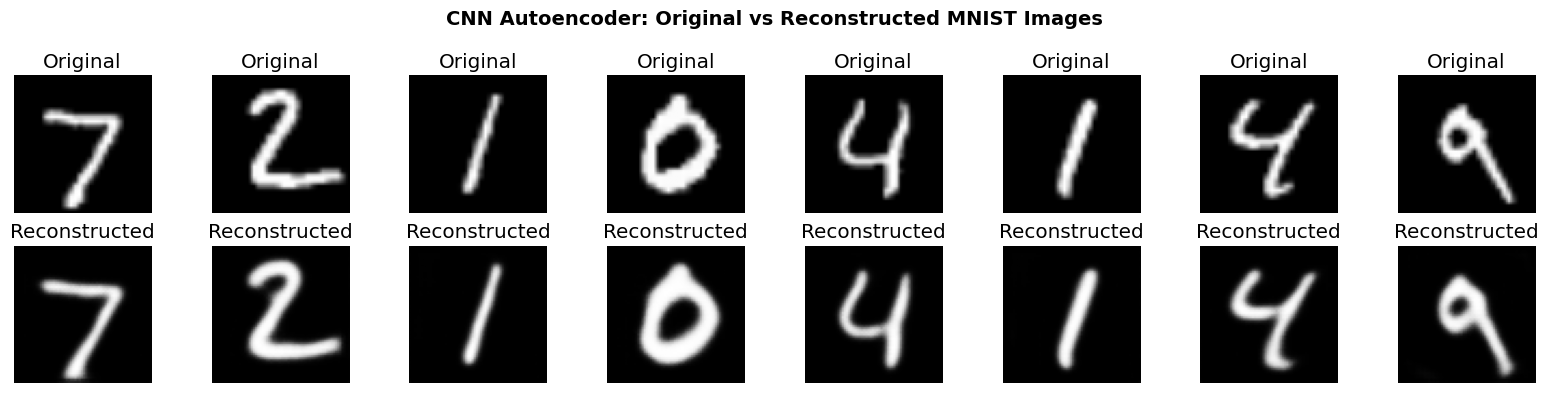

Latent dimension: 128
Compression ratio: 32.0:1

✓ CNN Autoencoder successfully compresses and reconstructs MNIST images!


In [ ]:
# ============================================================================
# PART 3: CNN AUTOENCODER FOR IMAGES - MNIST VERSION
# ============================================================================
#
# In this section, we'll build a Convolutional Neural Network (CNN) Autoencoder
# for image compression and reconstruction.
#
# Key concepts we'll explore:
# - Convolutional encoding (spatial → latent representation)
# - Transposed convolutions for decoding (latent → spatial)
# - Progressive downsampling and upsampling strategies
# - Compression ratios in learned representations

print("\n" + "="*80)
print("PART 3: CNN AUTOENCODER FOR MNIST IMAGE COMPRESSION")
print("="*80)

from typing import Tuple, Optional, Dict
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, Subset


def load_mnist_dataset(image_size: int = 64):
    """
    Load MNIST dataset with appropriate preprocessing.

    MNIST contains 28x28 grayscale images of handwritten digits (0-9).
    We resize to 64x64 for easier architecture design (powers of 2).

    Args:
        image_size: Target size for images (default 64x64)

    Returns:
        train_subset: Training data subset
        test_subset: Test data subset
        in_channels: Number of input channels (1 for grayscale)
    """
    print("Loading MNIST dataset...")

    # Transforms for MNIST (grayscale)
    # Note: We normalize to [-1, 1] range which works better with Tanh activation
    # Formula: (pixel_value - 0.5) / 0.5 maps [0,1] → [-1,1]
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),  # Resize from 28x28 to 64x64
        transforms.ToTensor(),                        # Convert PIL Image to tensor, scales to [0,1]
        transforms.Normalize([0.5], [0.5])           # Normalize to [-1, 1] for grayscale
    ])

    # Download and load the datasets
    # train=True gets training set (60,000 images)
    # train=False gets test set (10,000 images)
    train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
    in_channels = 1  # MNIST is grayscale (single channel)

    # Use subset for faster training in tutorial
    # In practice, you'd use the full dataset for better results
    # This speeds up the demo while still showing the concepts
    train_subset = Subset(train_dataset, range(min(5000, len(train_dataset))))
    test_subset = Subset(test_dataset, range(min(1000, len(test_dataset))))

    return train_subset, test_subset, in_channels


class ConvEncoder(nn.Module):
    """
    CNN Encoder for MNIST images.

    This encoder progressively reduces spatial dimensions while increasing
    the number of feature channels, creating a hierarchical representation.

    Architecture philosophy:
    - Progressive downsampling: toward low-res, high-channel "seed" feature map
      (This mimics how humans perceive: details → shapes → concepts)
    - Increasing channels as spatial dims decrease
      (Trade spatial resolution for semantic richness)
    - BatchNorm for training stability
      (Normalizes activations, reduces internal covariate shift)
    - LeakyReLU to avoid dead neurons
      (Unlike ReLU, allows small negative gradients, preventing "dead" units)

    Information flow:
    Input (1, 64, 64) → Conv blocks → (256, 4, 4) → Flatten → Linear → Latent (128,)
    """

    def __init__(self, in_channels: int = 1, latent_dim: int = 128,
                 image_size: int = 64):
        super().__init__()

        # Calculate size after convolutions
        # We'll downsample 4 times by factor of 2 each: 64 → 32 → 16 → 8 → 4
        self.image_size = image_size
        self.final_size = image_size // 16  # After 4 pooling layers: 64/16 = 4

        # Encoder layers - Each block increases channels and reduces spatial dims

        # Block 1: Extract low-level features (edges, corners)
        # 1 → 32 channels, spatial: 64x64 → 32x32
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1),  # Keep size
            nn.BatchNorm2d(32),                                              # Normalize
            nn.LeakyReLU(0.2),                                              # Non-linearity
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),          # Downsample by 2
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2)
        )

        # Block 2: Combine low-level features into mid-level patterns
        # 32 → 64 channels, spatial: 32x32 → 16x16
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),  # Downsample by 2
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )

        # Block 3: Extract higher-level features (parts of digits)
        # 64 → 128 channels, spatial: 16x16 → 8x8
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),  # Downsample by 2
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )

        # Block 4: Highest-level abstract features (digit identity)
        # 128 → 256 channels, spatial: 8x8 → 4x4
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),  # Downsample by 2
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        )

        # Flatten to latent vector
        # After conv4: (256, 4, 4) → Flatten → 256*4*4 = 4096 → Linear → 128
        self.flatten_size = 256 * self.final_size * self.final_size  # 256 * 4 * 4 = 4096
        self.fc = nn.Linear(self.flatten_size, latent_dim)           # 4096 → 128

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through encoder.

        Input shape: (batch_size, 1, 64, 64)
        Output shape: (batch_size, latent_dim)

        The network progressively reduces spatial information while
        building up a semantic representation.
        """
        # Progressive encoding with dimension tracking
        x = self.conv1(x)  # (B, 1, 64, 64) → (B, 32, 32, 32)
        x = self.conv2(x)  # (B, 32, 32, 32) → (B, 64, 16, 16)
        x = self.conv3(x)  # (B, 64, 16, 16) → (B, 128, 8, 8)
        x = self.conv4(x)  # (B, 128, 8, 8) → (B, 256, 4, 4)

        # Flatten and project to latent
        # view(x.size(0), -1) reshapes to (batch_size, everything_else_flattened)
        x = x.view(x.size(0), -1)  # (B, 256, 4, 4) → (B, 4096)
        z = self.fc(x)              # (B, 4096) → (B, 128)

        return z

class ConvDecoder(nn.Module):
    """
    CNN Decoder for MNIST images.

    The decoder mirrors the encoder but in reverse:
    - Takes compressed latent code and reconstructs the original image
    - Uses transposed convolutions (also called deconvolutions) for upsampling

    Mirror architecture of encoder:
    - Project from latent to spatial
    - Progressive upsampling with transposed convolutions
    - Decreasing channels as spatial dims increase

    Mathematical note on transposed convolutions:
    Regular convolution can be represented as matrix multiplication y = Cx
    where C is a sparse (block-)Toeplitz matrix. Transposed convolution
    computes y = C^T x, effectively "reversing" the convolution operation.
    """

    def __init__(self, out_channels: int = 1, latent_dim: int = 128,
                 image_size: int = 64):
        super().__init__()

        self.image_size = image_size
        self.final_size = image_size // 16  # Same calculation as encoder
        self.flatten_size = 256 * self.final_size * self.final_size

        # Project from latent back to spatial
        # This is the inverse of the encoder's final linear layer
        self.fc = nn.Linear(latent_dim, self.flatten_size)  # 128 → 4096

        # Decoder layers (transposed convolutions for upsampling) [D2L Ch 14.10]
        # why Conv is linear?? y=Cx, C is (block-)Toeplitz )
        # Note: ConvTranspose2d with stride=2 doubles spatial dimensions
        # Block 1: Upsample from 4x4 → 8x8, reduce channels 256 → 128
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1),  # Upsample x2
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),          # Refine features
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )

        # Block 2: Upsample from 8x8 → 16x16, reduce channels 128 → 64
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1),  # Upsample x2
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),           # Refine features
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )

        # Block 3: Upsample from 16x16 → 32x32, reduce channels 64 → 32
        self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),   # Upsample x2
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),            # Refine features
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2)
        )

        # Block 4: Final upsample from 32x32 → 64x64, produce output image
        self.deconv4 = nn.Sequential(
            nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1),   # Upsample x2
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, out_channels, kernel_size=3, stride=1, padding=1),  # Final projection
            nn.Tanh()  # Output in [-1, 1] to match the input normalization
                      # Tanh is crucial here - it bounds our output to [-1, 1]
        )

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through decoder.

        Input shape: (batch_size, latent_dim)
        Output shape: (batch_size, 1, 64, 64)

        The network progressively adds spatial detail while
        reducing the number of channels.
        """
        # Project and reshape from latent vector to spatial tensor
        x = self.fc(z)  # (B, 128) → (B, 4096)
        # Reshape to 4D tensor for convolutional layers
        x = x.view(x.size(0), 256, self.final_size, self.final_size)  # (B, 4096) → (B, 256, 4, 4)

        # Progressive decoding with upsampling
        x = self.deconv1(x)  # (B, 256, 4, 4) → (B, 128, 8, 8)
        x = self.deconv2(x)  # (B, 128, 8, 8) → (B, 64, 16, 16)
        x = self.deconv3(x)  # (B, 64, 16, 16) → (B, 32, 32, 32)
        x = self.deconv4(x)  # (B, 32, 32, 32) → (B, 1, 64, 64)

        return x

class CNNAutoencoder(nn.Module):
    """
    Complete CNN Autoencoder for MNIST.

    This combines the encoder and decoder into a single model.
    The autoencoder learns to:
    1. Compress images into a low-dimensional latent space (encoding)
    2. Reconstruct images from this compressed representation (decoding)

    The latent space acts as a bottleneck, forcing the network to learn
    the most important features for reconstruction.
    """

    def __init__(self, in_channels: int = 1, latent_dim: int = 128,
                 image_size: int = 64):
        super().__init__()
        # Initialize encoder and decoder as submodules
        self.encoder = ConvEncoder(in_channels, latent_dim, image_size)
        self.decoder = ConvDecoder(in_channels, latent_dim, image_size)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Full forward pass: encode then decode.

        Returns both reconstruction and latent code for analysis.
        """
        z = self.encoder(x)        # Compress to latent
        x_recon = self.decoder(z)  # Reconstruct from latent
        return x_recon, z

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        """Encode images to latent representations."""
        return self.encoder(x)

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        """Decode latent representations to images."""
        return self.decoder(z)


def train_cnn_autoencoder(model: CNNAutoencoder, train_loader: DataLoader,
                         num_epochs: int = 10, device: str = 'cpu'):
    """
    Train CNN autoencoder using reconstruction loss.

    The training objective is to minimize the difference between
    input images and their reconstructions. We use Mean Squared Error (MSE)
    as our loss function, which penalizes pixel-wise differences.

    Args:
        model: The autoencoder model to train
        train_loader: DataLoader providing training batches
        num_epochs: Number of training epochs
        device: Device to train on ('cpu' or 'cuda')

    Returns:
        losses: List of average losses per epoch
    """

    model = model.to(device)  # Move model to appropriate device

    # Adam optimizer with default learning rate
    # Adam adapts learning rate per parameter and uses momentum
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    print("\nTraining CNN Autoencoder on MNIST...")
    losses = []  # Track training progress

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode (enables dropout, batch norm updates)
        epoch_loss = 0
        batch_count = 0

        for batch_idx, (images, _) in enumerate(train_loader):
            # Note: We ignore labels (_) since this is unsupervised learning
            images = images.to(device)

            # Forward pass
            # Get both reconstructed images and latent representations
            recon_images, latent = model(images)

            # Calculate reconstruction loss
            # MSE loss computes mean((input - reconstruction)^2)
            # This encourages the model to accurately reconstruct inputs
            loss = F.mse_loss(recon_images, images)

            # Backward pass
            optimizer.zero_grad()  # Clear gradients from previous step
            loss.backward()        # Compute gradients via backpropagation
            optimizer.step()       # Update model parameters

            epoch_loss += loss.item()
            batch_count += 1

            # Print progress every 50 batches
            if batch_idx % 50 == 0:
                print(f"  Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], "
                      f"Loss: {loss.item():.4f}")

        # Calculate and store average epoch loss
        avg_loss = epoch_loss / batch_count
        losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {avg_loss:.4f}")

    return losses

def visualize_reconstructions(model: CNNAutoencoder, test_loader: DataLoader,
                             device: str = 'cpu', num_examples: int = 8):
    """
    Visualize original vs reconstructed MNIST images.

    This function helps us assess the quality of our autoencoder by
    comparing original images with their reconstructions side by side.

    Args:
        model: Trained autoencoder model
        test_loader: DataLoader with test images
        device: Device model is on
        num_examples: Number of examples to visualize
    """

    model.eval()  # Set to evaluation mode (disables dropout, uses running stats for batch norm)

    # Get a batch of test images
    images, _ = next(iter(test_loader))
    images = images[:num_examples].to(device)  # Select first num_examples images

    # Generate reconstructions without computing gradients (more efficient)
    with torch.no_grad():
        recon_images, latent = model(images)

    # Move to CPU for visualization (matplotlib needs CPU tensors)
    images = images.cpu()
    recon_images = recon_images.cpu()

    # Denormalize images from [-1, 1] back to [0, 1] for display
    # Reverse the normalization: x' = x * std + mean
    images = images * 0.5 + 0.5
    recon_images = recon_images * 0.5 + 0.5
    # Clamp to ensure values are in valid range [0, 1]
    recon_images = torch.clamp(recon_images, 0, 1)

    # Create visualization plot
    fig, axes = plt.subplots(2, num_examples, figsize=(16, 4))

    for i in range(num_examples):
        # Original - squeeze removes channel dimension (1, 64, 64) → (64, 64)
        axes[0, i].imshow(images[i].squeeze(), cmap='gray')
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')

        # Reconstructed - squeeze removes channel dimension
        axes[1, i].imshow(recon_images[i].squeeze(), cmap='gray')
        axes[1, i].set_title('Reconstructed')
        axes[1, i].axis('off')

    plt.suptitle('CNN Autoencoder: Original vs Reconstructed MNIST Images',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Print compression statistics
    # This shows how much we've compressed the data
    print(f"Latent dimension: {latent.shape[1]}")
    # Compression ratio = input_size / latent_size
    print(f"Compression ratio: {images[0].numel() / latent[0].numel():.1f}:1")

# ============================================================================
# MAIN EXECUTION: Train and evaluate the CNN autoencoder
# ============================================================================

# Train CNN Autoencoder on MNIST
print("\nSetting up CNN Autoencoder training for MNIST...")

# Load and prepare datasets
# image_size=64 gives us nice power-of-2 dimensions for the architecture
train_dataset, test_dataset, in_channels = load_mnist_dataset(image_size=64)

# Create data loaders for batched training
# batch_size=64 is a good balance between memory usage and training stability
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Create and initialize model
# latent_dim=128 means we compress 64*64=4096 pixels to just 128 numbers!
cnn_ae = CNNAutoencoder(in_channels=in_channels, latent_dim=128, image_size=64)

# Print model complexity
print(f"Model parameters: {sum(p.numel() for p in cnn_ae.parameters()):,}")

# Train for fewer epochs for demo (in practice, train for 20-50 epochs)
# Check if GPU is available for faster training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
losses = train_cnn_autoencoder(cnn_ae, train_loader, num_epochs=5, device=device)

# Visualize results to assess reconstruction quality
visualize_reconstructions(cnn_ae, test_loader, device=device)

print("\n✓ CNN Autoencoder successfully compresses and reconstructs MNIST images!")
# The model has learned to compress 4096-dimensional images into 128-dimensional
# latent codes while preserving enough information for reconstruction!

### To learn more about deconvolution, watch this: https://www.youtube.com/watch?v=ilkSwsggSNM

### In the reconstruction Expect artifacts, as NN finds ways to hack the loss minimization (e.g. checkerboard artifacts)

### Note that, in the `CNNAutoencoder` class, `self.encoder` and `self.decoder` are **instances** of the `ConvEncoder` and `ConvDecoder` classes.
When you call `self.encoder(x)`, you're calling the `ConvEncoder` **object** as if it were a function. This works because:

1. **All PyTorch `nn.Module` classes have a `__call__` method** that's inherited from the base `nn.Module` class
2. **When you use parentheses `()` on an object, Python calls its `__call__` method**
3. **The `__call__` method in `nn.Module` automatically calls the `forward()` method**

So the flow is:
```
self.encoder(x)
    ↓
ConvEncoder.__call__(x)  # Inherited from nn.Module
    ↓  
ConvEncoder.forward(x)   # Our custom forward method
```

You can verify this works the same way:
```python
# These are equivalent:
z = self.encoder(x)           # Calls __call__ which calls forward
z = self.encoder.forward(x)   # Direct call to forward
```

This is a common PyTorch pattern - you store neural network layers/modules as attributes, then call them like functions. The `nn.Module.__call__` method also handles other important stuff like:
- Registering forward/backward hooks
- Gradient computation setup  
- Moving between train/eval modes

That's why we always call modules with `()` rather than calling `.forward()` directly!

# Uses of the Learned Latent Representation

The latent $z$ is a **compact representation** learned to preserve information needed to reconstruct MNIST digit images $x$. Common uses:

* **Compression**: store/transmit $z$ (128-dim) instead of the full MNIST image (64×64 = 4096 pixels).
* **Denoising**: train with noisy digit inputs, reconstruct clean digit images.
* **Anomaly detection**: train on digits 0-9; high reconstruction error flags non-digits or corrupted samples.
* **Digit retrieval**: index MNIST images by $z$ vectors (use cosine distance to find similar digit styles).
* **Downstream features**: use $z$ as input to a digit classifier, style transfer, or clustering digits by writing style.

### Using it for MNIST Classification (two clean options)

**A) Frozen encoder + linear head**

```python
class MNIST_AE_Classifier(nn.Module):
    def __init__(self, encoder: nn.Module, latent_dim: int = 128, n_classes: int = 10):
        super().__init__()
        self.encoder = encoder.eval()          # use learned MNIST encoder
        for p in self.encoder.parameters():     # freeze if desired
            p.requires_grad = False
        self.head = nn.Linear(latent_dim, n_classes)  # 128 -> 10 digits

    def forward(self, x):
        with torch.no_grad():
            z = self.encoder(x)                 # (N, 128)
        logits = self.head(z)                   # (N, 10) for digits 0-9
        return logits
```

Train only the classification head with cross-entropy on digit labels. Fast and sample-efficient since the encoder has already learned useful MNIST features.

**B) Joint fine-tuning**
Add a digit classification head on top of $z$ and optimize:

$$
\mathcal{L} = \lambda_{\text{recon}}\underbrace{\| \hat{x}-x\|_2^2}_{\text{reconstruction loss}}
+ \lambda_{\text{cls}}\underbrace{\mathrm{CE}(\text{head}(z), y)}_{\text{digit classification}}.
$$

This can improve latent features for digit recognition while preserving reconstruction quality of MNIST images (set $\lambda$'s to balance reconstruction vs classification).

**Example usage:**
```python
# Use our trained MNIST autoencoder
mnist_classifier = MNIST_AE_Classifier(cnn_ae.encoder, latent_dim=128, n_classes=10)

# Train only the head, or fine-tune the whole thing
optimizer = torch.optim.Adam(mnist_classifier.head.parameters(), lr=0.001)  # Option A
# optimizer = torch.optim.Adam(mnist_classifier.parameters(), lr=0.0001)    # Option B
```

> **Note**: For purely supervised MNIST classification, a simple CNN often works better than autoencoder features. However, for tasks like detecting non-digits, finding unusual writing styles, or few-shot learning on new digit datasets, the autoencoder's reconstruction-based features can be very valuable.